In [1]:
from scengen.exp.experiment import ComparisonExperiment
from scengen.generators import PredClusGenerator, SampleGenerator, RandomGenerator

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd

## Util to generate random data

In [4]:
random_gen = np.random.default_rng(12341)
def random_dataset(N):
    attributes = random_gen.random(size = (N, 25))
    timeseries = random_gen.random(size = (N, 24*4))
    folds = np.array_split(np.arange(0, N, dtype= 'int'), 5)
    return attributes, timeseries, folds

## Experiment interface to easily run experiments

In [5]:
from sklearn.tree import DecisionTreeRegressor
from pathlib import Path



experiment = (
    ComparisonExperiment(result_path = Path('results/first_test'), nb_of_samples = 250)
    .add_methods(
        predictive_clustering =  PredClusGenerator(DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 100)),
        deep_predictive_clustering = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 100)),
        random_baseline = RandomGenerator(),
    )
    .add_datasets(
        random_dataset = random_dataset(1000),
        deep_random_dataset = random_dataset(10000)
    )
)

energy_scores, timing_df = experiment.execute()




Methods: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 138.73it/s, method=random_baseline]


In [6]:
energy_scores.mean(axis = 0).to_frame('ES')

ES
predictive_clustering      random_dataset       1.600256
                           deep_random_dataset  1.586180
deep_predictive_clustering random_dataset       1.600099
                           deep_random_dataset  1.595053
random_baseline            random_dataset       1.587108
                           deep_random_dataset  1.583526

In [7]:
timing_df

training_time  predict_time  \
predictive_clustering      random_dataset            0.061019      0.050253   
                           deep_random_dataset       0.954830      0.212758   
deep_predictive_clustering random_dataset            0.057783      0.035363   
                           deep_random_dataset       1.554065      0.225117   
random_baseline            random_dataset            0.001014      0.002900   
                           deep_random_dataset       0.009206      0.016619   

                                                eval_time  
predictive_clustering      random_dataset        1.691875  
                           deep_random_dataset  11.465797  
deep_predictive_clustering random_dataset        1.303460  
                           deep_random_dataset  11.162136  
random_baseline            random_dataset        1.209708  
                           deep_random_dataset  11.206723

## Use model directly
PredClusGenerator return indices into the training data as samples

In [8]:
model =  PredClusGenerator(DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 100))
attributes, timeseries, _ = random_dataset(1000)
model.fit(attributes, timeseries)

test_attributes = np.random.random(size = (1, attributes.shape[1]))
indices = model.generate(test_attributes, nb_of_samples=100)
indices

array([[194, 325, 897, 944, 102, 674, 193, 356,  77, 926, 356,  38, 284,
        154, 836, 102, 220, 284, 701, 216, 551, 284, 734, 378, 497, 259,
        476, 671, 417, 194, 917, 526,  49, 342, 730, 939, 647, 569, 497,
         22,  48, 917, 647, 725, 824, 873, 414, 490, 154, 107, 675, 271,
        734, 175, 877, 293, 376, 210, 698, 526, 490, 395, 691, 401,  53,
        109, 102, 460, 245,  24,  79, 293, 763, 971, 971, 356, 533, 314,
         77, 107, 342,  38, 944, 734, 259, 465,  38,  86, 734, 809, 210,
        154, 293, 414, 122, 836, 897, 495, 607, 675]])

In [9]:
timeseries[indices]

array([[[0.73111924, 0.45880793, 0.88444433, ..., 0.85903956,
         0.45836454, 0.05601404],
        [0.32403118, 0.97405972, 0.61039892, ..., 0.05879885,
         0.28454369, 0.51131031],
        [0.59188768, 0.65975401, 0.07824057, ..., 0.18222488,
         0.50012114, 0.04094164],
        ...,
        [0.53761217, 0.61552401, 0.09254874, ..., 0.75273028,
         0.53454437, 0.20348194],
        [0.370653  , 0.82356436, 0.07333274, ..., 0.17087055,
         0.2939785 , 0.48386065],
        [0.65342291, 0.49280035, 0.12943976, ..., 0.04602878,
         0.69223161, 0.93858068]]])

## Or use SampleGenerator

In [10]:
model =  SampleGenerator(PredClusGenerator(DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 100)))
attributes, timeseries, _ = random_dataset(1000)
model.fit(attributes, timeseries)

test_attributes = np.random.random(size = (1, attributes.shape[1]))
timeseries = model.generate_timeseries(test_attributes, nb_of_samples=100)
timeseries

array([[[0.62589861, 0.28882068, 0.08266036, ..., 0.37584439,
         0.52643536, 0.93936622],
        [0.96748478, 0.97296843, 0.87236861, ..., 0.06427894,
         0.40565832, 0.73673276],
        [0.41952385, 0.03909334, 0.91999629, ..., 0.92137932,
         0.36301646, 0.29875235],
        ...,
        [0.1814669 , 0.91849658, 0.85853605, ..., 0.59708933,
         0.03363665, 0.64738642],
        [0.29244119, 0.71541336, 0.05405638, ..., 0.43176323,
         0.94654373, 0.61028967],
        [0.78321737, 0.43189694, 0.90190306, ..., 0.00837393,
         0.96097995, 0.17289991]]])

# Interpretability

This package also contains a few utilities to help interpret the resulting model 

In [11]:
# fit a model
model =  PredClusGenerator(DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 100))
attributes, timeseries, _ = random_dataset(1000)
model.fit(attributes, timeseries)

In [12]:
# for interpretability feature names are required
attribute_df = pd.DataFrame(attributes, columns = [f"attr{i}" for i in range(attributes.shape[1])])
attribute_df

,attr0,attr1,attr2,attr3,attr4,attr5,attr6,attr7,attr8,attr9,...,attr15,attr16,attr17,attr18,attr19,attr20,attr21,attr22,attr23,attr24
0,0.692441,0.059896,0.544142,0.165928,0.609031,0.959206,0.495946,0.148448,0.824851,0.867433,...,0.347669,0.663253,0.029603,0.486543,0.094075,0.274501,0.148659,0.934861,0.719100,0.758736
1,0.653577,0.460738,0.056944,0.513941,0.530944,0.021042,0.960407,0.283877,0.309032,0.964300,...,0.039188,0.093603,0.546264,0.814297,0.476044,0.739077,0.070448,0.678360,0.934743,0.125120
2,0.250955,0.411590,0.280800,0.651612,0.429420,0.546009,0.964668,0.612551,0.215624,0.747472,...,0.242942,0.133466,0.334163,0.172749,0.405985,0.139698,0.706807,0.535719,0.443738,0.382333
3,0.621485,0.953965,0.212557,0.939721,0.996057,0.331017,0.708848,0.566220,0.737413,0.711724,...,0.627942,0.518980,0.564393,0.806633,0.291994,0.635103,0.121531,0.741970,0.224326,0.701865
4,0.548506,0.884029,0.798465,0.597678,0.663515,0.437451,0.392197,0.113985,0.550343,0.829213,...,0.734874,0.367752,0.681423,0.684703,0.533765,0.569432,0.923985,0.872256,0.415163,0.341439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.162732,0.732249,0.420196,0.548666,0.555676,0.886040,0.169788,0.370315,0.073148,0.474483,...,0.648511,0.371314,0.214533,0.315618,0.308136,0.793549,0.549511,0.333929,0.274159,0.208639
996,0.808569,0.292004,0.574354,0.110366,0.767397,0.477785,0.309464,0.261878,0.548981,0.600114,...,0.795875,0.416503,0.950687,0.928663,0.628912,0.481782,0.688408,0.348863,0.927244,0.366376
997,0.187726,0.654122,0.936419,0.069893,0.168261,0.633125,0.685909,0.143940,0.825287,0.035072,...,0.953851,0.505642,0.735299,0.818089,0.460533,0.270747,0.671460,0.177156,0.086777,0.074737
998,0.424625,0.217427,0.670059,0.922830,0.820212,0.318628,0.840138,0.265479,0.747059,0.164923,...,0.776548,0.514870,0.612272,0.883346,0.113286,0.868412,0.018726,0.216879,0.677758,0.575205


In [13]:
timeseries_df = pd.DataFrame(timeseries, columns = pd.date_range(start = '2016-01-01 00:00', freq = '15min', periods = 4*24))
timeseries_df

,2016-01-01 00:00:00,2016-01-01 00:15:00,2016-01-01 00:30:00,2016-01-01 00:45:00,2016-01-01 01:00:00,2016-01-01 01:15:00,2016-01-01 01:30:00,2016-01-01 01:45:00,2016-01-01 02:00:00,2016-01-01 02:15:00,...,2016-01-01 21:30:00,2016-01-01 21:45:00,2016-01-01 22:00:00,2016-01-01 22:15:00,2016-01-01 22:30:00,2016-01-01 22:45:00,2016-01-01 23:00:00,2016-01-01 23:15:00,2016-01-01 23:30:00,2016-01-01 23:45:00
0,0.366445,0.053216,0.465619,0.086879,0.883968,0.449384,0.315824,0.873006,0.454873,0.615023,...,0.660367,0.540789,0.007196,0.405135,0.312584,0.643406,0.258884,0.440231,0.145053,0.880365
1,0.841387,0.042516,0.205385,0.463352,0.763880,0.407682,0.753332,0.607109,0.572835,0.392249,...,0.605618,0.871575,0.406618,0.002934,0.578913,0.151046,0.057875,0.374503,0.358632,0.421294
2,0.366029,0.364190,0.844942,0.627292,0.210029,0.161550,0.496854,0.845299,0.896829,0.969067,...,0.711771,0.555864,0.719403,0.865850,0.439824,0.140633,0.029212,0.589009,0.577378,0.739680
3,0.397395,0.673549,0.714841,0.208604,0.240663,0.353654,0.115293,0.814636,0.663151,0.383806,...,0.343266,0.679608,0.237390,0.668081,0.422847,0.688927,0.766667,0.655252,0.947538,0.954494
4,0.583548,0.603430,0.043757,0.917595,0.603938,0.156114,0.547048,0.536131,0.730575,0.648655,...,0.661920,0.441601,0.878362,0.507879,0.912396,0.256425,0.419988,0.541593,0.273703,0.124052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.345895,0.878402,0.658928,0.511090,0.358643,0.330428,0.906077,0.619646,0.996524,0.869556,...,0.650347,0.575136,0.212004,0.213332,0.041198,0.701514,0.368321,0.270015,0.455661,0.981577
996,0.215345,0.267490,0.149750,0.240264,0.618682,0.906617,0.593875,0.748355,0.346068,0.384779,...,0.230239,0.681564,0.038241,0.537679,0.362968,0.919452,0.536794,0.201397,0.603048,0.668215
997,0.932702,0.399491,0.189984,0.477974,0.745639,0.928273,0.759111,0.813833,0.732599,0.554755,...,0.368237,0.498269,0.317603,0.503410,0.358422,0.187813,0.088749,0.685682,0.911064,0.589584
998,0.379911,0.443940,0.599754,0.698007,0.455900,0.693977,0.583927,0.036500,0.547128,0.478955,...,0.325675,0.687458,0.309359,0.837209,0.888372,0.013849,0.340400,0.247533,0.592173,0.049162


In [14]:
vistree = model.to_visualization_tree(attribute_df)
vistree

## For easy visualization you can compress the tree 
This operation compresses multiple binary splits on the same attribute to a single n-ary split  
(in this random examples this won't have any influence on the result)

In [15]:
vistree = vistree.compress_tree()

## quick visualization with printing

In [16]:
vistree.print_tree()

(0) attr0 ≤ 0.34
	(1) attr21 ≤ 0.58
		 ⤇ leaf 0
	(1) attr21 > 0.58
		 ⤇ leaf 1
(0) attr0 > 0.34
	(2) attr7 ≤ 0.33
		(3) attr3 ≤ 0.50
			 ⤇ leaf 2
		(3) attr3 > 0.50
			 ⤇ leaf 3
	(2) attr7 > 0.33
		(4) attr15 ≤ 0.34
			 ⤇ leaf 4
		(4) attr15 > 0.34
			(5) attr17 ≤ 0.64
				 ⤇ leaf 5
			(5) attr17 > 0.64
				 ⤇ leaf 6


## More extensive visualization through plotting

The node_ids are in grey (suggestions for better placement are welcome)

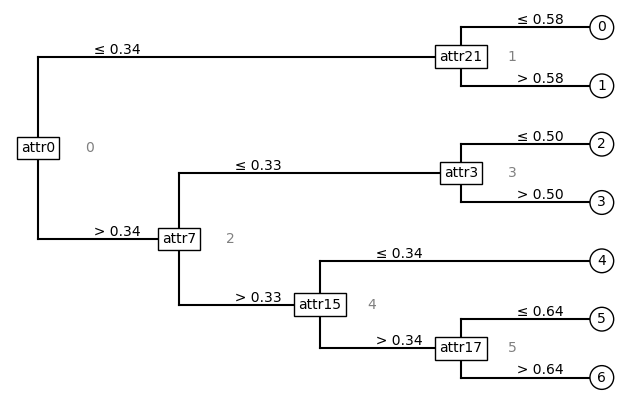

In [17]:
vistree.plot_tree(figsize = (8,5)) # You might have to tinker with the aspect ratio and size to get a readeable figure 

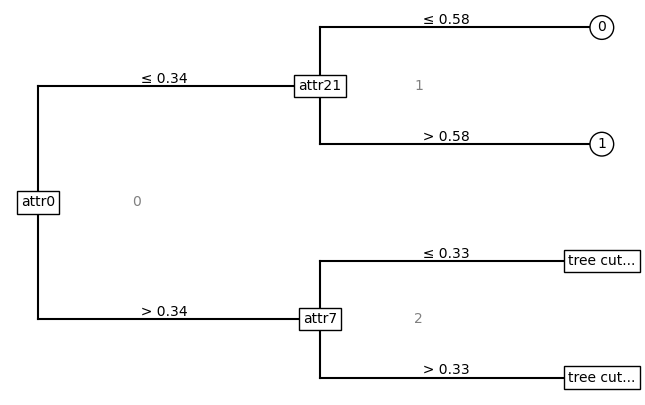

In [18]:
# You can cut of the visualization to a certain depth
vistree.plot_tree(figsize = (8,5), max_depth = 2) 

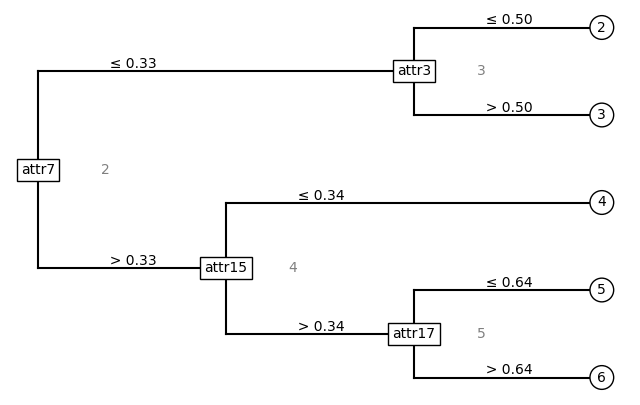

In [19]:
# Or you can plot a certain subtree using a node_id (numbers in gray) 
vistree.plot_subtree(2, figsize = (8,5)) 

In [20]:
# You can get a specific node using get_node
vistree.get_node(0)

In [21]:
# same principle for the leaf nodes 

In [22]:
vistree.get_leaf(1)

## You can get the instances in each node 

In [28]:
vistree.get_leaf(2).instances

array([  0,   7,   9,  10,  24,  26,  30,  56,  64,  67,  68,  96,  98,
       100, 110, 129, 132, 140, 141, 144, 160, 161, 184, 185, 191, 195,
       208, 210, 225, 262, 264, 286, 291, 293, 294, 304, 308, 311, 331,
       338, 339, 354, 358, 365, 366, 378, 414, 439, 445, 452, 470, 478,
       479, 482, 483, 491, 497, 513, 520, 528, 536, 537, 546, 554, 555,
       556, 557, 560, 562, 567, 585, 590, 592, 619, 620, 622, 636, 648,
       653, 655, 660, 681, 683, 685, 701, 708, 714, 717, 718, 731, 746,
       771, 787, 788, 791, 804, 805, 819, 824, 825, 847, 848, 862, 867,
       876, 890, 900, 907, 912, 916, 920, 940, 946, 954, 962, 971, 972,
       976, 988, 996])

In [29]:
vistree.get_leaf(2).nb_of_instances

120

## In this tree the individual nodes have more precise plotting functionalities

In [117]:
vistree.get_node(3).plot_attribute_distribution(attribute_df, nb_of_bins = 20)

alt.LayerChart(...)

In [118]:
vistree.get_node(3).plot_attribute_distribution(attribute_df, kde = True, bandwidth = None)

alt.LayerChart(...)

In [119]:
vistree.get_node(3).plot_feature_correlations(attribute_df)

alt.Chart(...)

In [150]:
vistree.get_node(4).plot_timeseries(timeseries_df)

alt.Chart(...)

In [151]:
vistree.root_node.plot_timeseries_quantiles(timeseries_df)

alt.Chart(...)

In [149]:
vistree.root_node.plot_children(timeseries_df)

alt.HConcatChart(...)